## Estimating Crowd Size on Bridge using Traditional Computer Vision Techniques

#### The proposed solution processes the video frame by frame to estimate the number of people on the bridge. For each frame, the background will be removed to isolate the bridge or road area, ensuring that only relevant regions are considered for analysis. Due to the nature of the footage (drone footage), where individuals are not distinctly identifiable, traditional object detection techniques may not be effective. Blob Detection is used to identify and estimate the number of people in each frame.

#### Now for the 2nd part of the solution, how do we ensure that the same person is not being counted multiple times as we process subsequent frames? To prevent counting the same person multiple times across consecutive frames, a centroid tracking algorithm is used. For each frame, when a person is detected, the algorithm checks if a person was also detected in the previous frame within the same pixel neighborhood (e.g., within a 200-pixel radius). If so, it is assumed to be the same person, and they are not counted again. If no match is found in the previous frame, the person is counted as a new individual. 

#### Reasons for thresholds:
#### There are around 210,000 pixels in each frame. it is safe to assume that a person occupies 100 pixels. 

#### (Actual detection screenshots included, people are detected and marked with a green circle.)

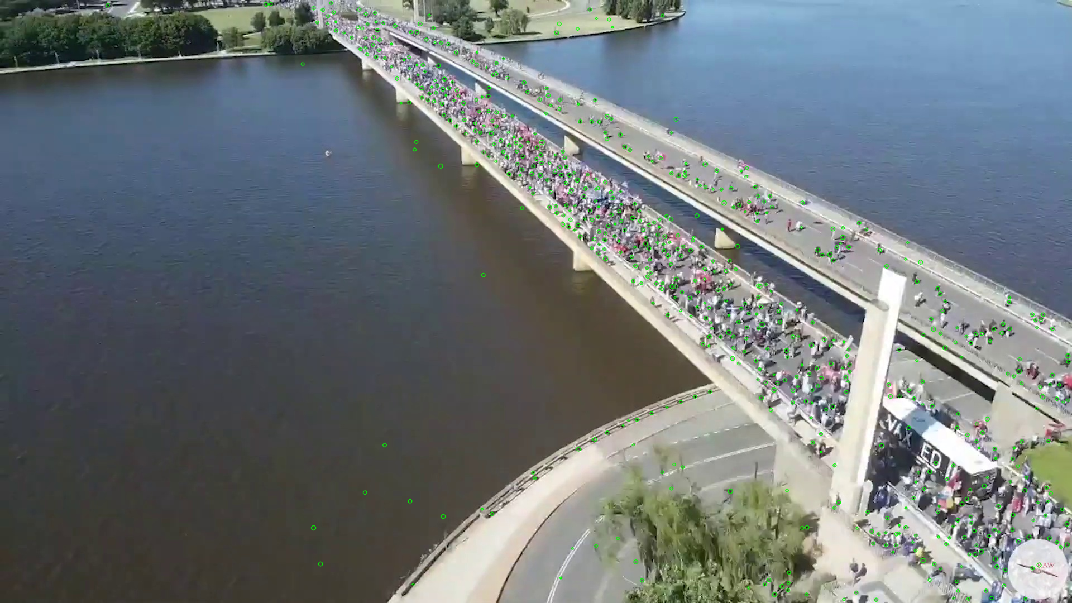

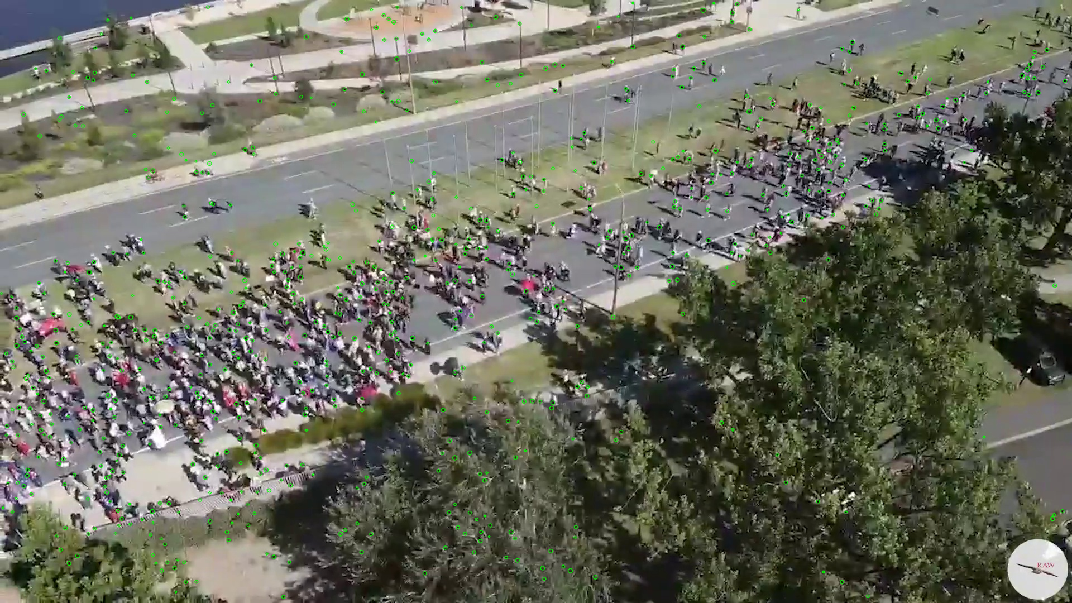

In [1]:
import cv2
import numpy as np
import math

'''
Function to track people across frames to identify if a new person has been detected.
'''
def track_objects(current_centroids, prev_centroids, total_count, max_distance=200):
    for new_centroid in current_centroids:
        matched = False
        for prev_centroid in prev_centroids:
            distance = np.linalg.norm(np.array(new_centroid) - np.array(prev_centroid))
            if distance < max_distance:
                prev_centroids.remove(prev_centroid)
                matched = True
                break
        if not matched:
            total_count += 1
    
    return total_count

'''
Function to smoothen the number of people detected by averaging the number of people
detected across 15 frames. To ensure no drastic changes in number of detected people.
'''
def smooth_count(counts, window_size=15):
    if len(counts) < window_size:
        return int(np.mean(counts))
    else:
        return int(np.mean(counts[-window_size:]))

'''
Function to isolate background from the bridge/road.
Background here includes green trees, hence green objects are identified and
ignored from the frame.
'''
def segment_bridge(frame):
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    lower_green = np.array([35, 40, 40], dtype=np.uint8)
    upper_green = np.array([85, 255, 255], dtype=np.uint8)
    
    green_mask = cv2.inRange(hsv_frame, lower_green, upper_green)
    non_green_mask = cv2.bitwise_not(green_mask)
    segmented_road = cv2.bitwise_and(frame, frame, mask=non_green_mask)
    
    return segmented_road

'''
image preprocessing techniques to remove noise before blob detection.
'''
def preprocess_for_blob_detection(frame, roi_corners=None):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame, (5, 5), 0)
    return frame

def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

'''
The same blob is identified multiple times. To prevent recounting 
already identified blob/person duplicates/near duplicate centroids are 
removed.
'''
def remove_near_duplicates(points, threshold=100):
    unique_points = []
    for point in points:
        is_unique = True
        for unique_point in unique_points:
            if euclidean_distance(point, unique_point) <= threshold:
                is_unique = False
                break
        if is_unique:
            unique_points.append(point)
    return unique_points

'''
Blob detection using cv2.SimpleBlobDetector
'''
def detect_blobs(frame, original):
    frame = preprocess_for_blob_detection(frame)

    params = cv2.SimpleBlobDetector_Params()
    
    params.filterByArea = True
    params.minArea = 10
    params.maxArea = 50
    params.filterByCircularity = True
    params.minCircularity = 0.5
    params.filterByConvexity = True
    params.minConvexity = 0.75
    params.filterByInertia = True
    params.minInertiaRatio = 0.2

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(frame)

    frame_with_blobs = cv2.drawKeypoints(original, keypoints, np.array([]), (0, 255, 0),
                                         cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    centroids = [(int(k.pt[0]), int(k.pt[1])) for k in keypoints]
    centroids = remove_near_duplicates(centroids)
    
    return centroids, frame_with_blobs, len(keypoints)

'''
Helper function to analyse the given clip.
'''
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    
    prev_centroids = []
    total_people_count = 0
    people_count_over_time = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        original = frame.copy()

        segmented_bridge = segment_bridge(frame)
        
        current_centroids, frame_with_blobs, len_keypoints = detect_blobs(segmented_bridge, original)

        total_people_count = track_objects(current_centroids, prev_centroids, total_people_count)
        prev_centroids = current_centroids

        people_count_over_time.append(total_people_count)
        smoothed_count = smooth_count(people_count_over_time)

        out.write(frame_with_blobs)
        
    cap.release()
    out.release()
    print(f"Total number of people detected: {smoothed_count}")

video_path = 'input_clip.mp4'
process_video(video_path)

Total number of people detected: 2644


## Validation

#### One way to validate the solution is by comparing consecutive frames to ensure consistency in the number of people detected. In an accurate method or model, the number of people identified in two successive frames should remain relatively stable, without significant fluctuations.

In [2]:
total_people_count = 0
prev_centroids = []
people_count_over_time = []

frame = cv2.imread("frames/frame_0.jpg")
original = frame.copy()
segmented_bridge = segment_bridge(frame)
current_centroids, frame_with_blobs, len_keypoints = detect_blobs(segmented_bridge, original)
total_people_count = track_objects(current_centroids, prev_centroids, total_people_count)

prev_centroids = current_centroids
people_count_over_time.append(total_people_count)
smoothed_count1 = smooth_count(people_count_over_time)

frame = cv2.imread("frames/frame_1.jpg")
original = frame.copy()
segmented_bridge = segment_bridge(frame)
current_centroids, frame_with_blobs, len_keypoints = detect_blobs(segmented_bridge, original)
total_people_count = track_objects(current_centroids, prev_centroids, total_people_count)

prev_centroids = current_centroids
people_count_over_time.append(total_people_count)
smoothed_count2 = smooth_count(people_count_over_time)
print(f"Difference in the number of people detected in two consecutive frame: {abs(smoothed_count1-smoothed_count2)}")

Difference in the number of people detected in two consecutive frame: 5


## Alternative Solutions

#### Another idea I considered was converting the side-view footage to a bird's-eye view. However, this would require precise knowledge of the coordinates of the region of interest (the bridge or road). Implementing this would likely involve deep learning-based segmentation techniques to accurately identify the area. Since the assessment focused on using traditional computer vision techniques, this approach may not be suitable. Additionally, perspective warping poses the risk of losing valuable information, as parts of the image may be cropped during the transformation.

#### There are also density-based methods to estimate crowd sizes in frames. However, these techniques typically rely on deep learning models that must be fine-tuned to the specific use case using images from a similar distribution.

#### I had also considered using the SORT algorithm (https://github.com/abewley/sort) for object tracking. However, I was unable to configure and implement it on my local machine due to time constraints.

#### Other common pretrained model used for object detection and tracking, will not be suitale for this task as the people in the footage look extremely small, which is very different from the data these models were trained on. Hence it wont be able to identify people from Drone Footage.